In [1]:
!pip install dtaidistance tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 18.4 MB/s eta 0:00:00


In [2]:
# Core & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Signal Processing & Time Series
from scipy import stats
from collections import Counter
from scipy.signal import find_peaks
from dtaidistance import dtw
from tslearn.metrics import dtw as tslearn_dtw
from tslearn.clustering import TimeSeriesKMeans

# ML & Dimensionality Reduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

# Network Analysis
import networkx as nx
import networkx.algorithms.community as nx_comm

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, LSTM, Input, RepeatVector, TimeDistributed,
    GRU, Conv1D, MaxPooling1D, UpSampling1D, 
    Flatten, Reshape
)
from tensorflow.keras.callbacks import EarlyStopping

# Config
warnings.filterwarnings("ignore", category=UserWarning, module='dtaidistance')

In [3]:
# Cell 3: Load Data
data_path = '/kaggle/input/Data-Traffic.xlsx'
df = pd.read_excel(data_path)
sites = df['site']
power_data = df.iloc[:, 1:]

In [4]:
# Cell 4: Filter out hours
hours_to_keep = [0, 1] + list(range(7, 24))  # Keep 0, 1, 7-23 (Corrected range)
filtered_power_data = power_data.iloc[:, hours_to_keep]

In [5]:
# Cell 5: Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(filtered_power_data.T).T
normalized_df = pd.DataFrame(
    normalized_data,
    columns=[filtered_power_data.columns[i] for i in range(len(filtered_power_data.columns))],
    index=filtered_power_data.index,
)

In [6]:
# Cell 6: Time Series K-means with DTW
n_clusters = 3
print("Performing Time Series K-means clustering with DTW...")
ts_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, random_state=42, n_jobs=-1)
kmeans_labels = ts_km.fit_predict(normalized_data.reshape(len(normalized_data), -1, 1))

Performing Time Series K-means clustering with DTW...


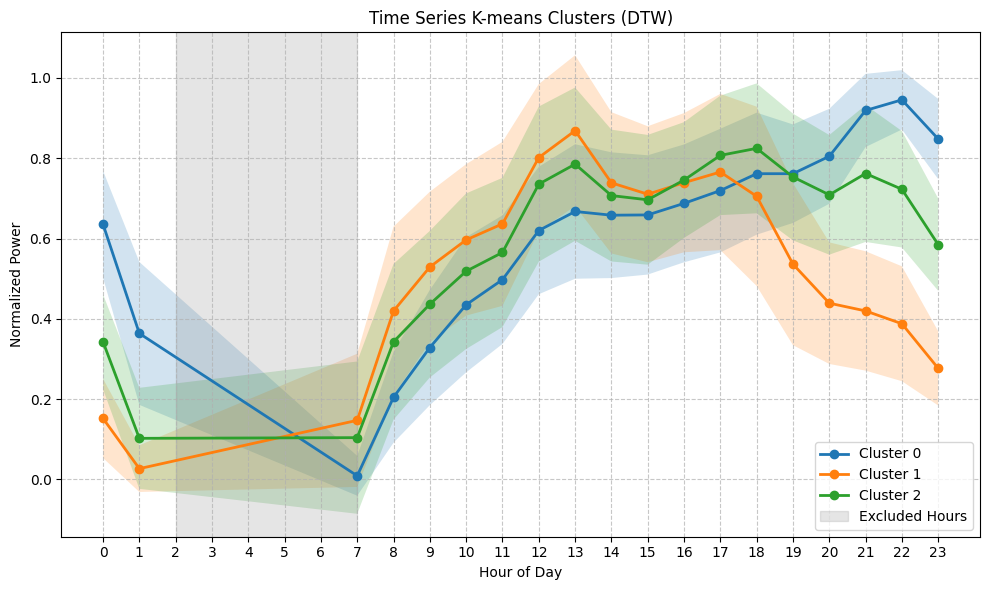

In [7]:
# Cell 7: Plot Time Series K-means Clusters
fig = plt.figure(figsize=(10, 6))
hour_indices = hours_to_keep
for cluster in range(n_clusters):
    cluster_data = normalized_df[kmeans_labels == cluster].mean()
    plt.plot(hour_indices, cluster_data, linewidth=2, label=f'Cluster {cluster}', marker='o')
    cluster_std = normalized_df[kmeans_labels == cluster].std()
    plt.fill_between(hour_indices, cluster_data - cluster_std, cluster_data + cluster_std, alpha=0.2)

plt.title('Time Series K-means Clusters (DTW)')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Power')
plt.xticks(range(24))
plt.axvspan(2, 7, alpha=0.2, color='gray', label='Excluded Hours')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
# Cell 8: Configure GPU memory growth
print("Configuring GPU memory growth...")
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Configuring GPU memory growth...


In [9]:
# Cell 9: Define LSTM Autoencoder Model
print("Building LSTM Autoencoder...")
timesteps = normalized_data.shape[1]  # Should be 18 now (24 - 6)
features = 1
encoding_dim = 8

# Build encoder
inputs = Input(shape=(timesteps, features))
encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(16, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Build decoder
decoder_input = Input(shape=(encoding_dim,))
decoded = RepeatVector(timesteps)(decoder_input)
decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(features))(decoded)

# Define autoencoder model
autoencoder = Model(inputs, Model(decoder_input, decoded)(encoded))
encoder = Model(inputs, encoded)

# Compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

Building LSTM Autoencoder...


In [10]:
# Cell 10: Train LSTM Autoencoder
print("Training LSTM Autoencoder...")
reshaped_data = normalized_data.reshape(len(normalized_data), timesteps, features)
history = autoencoder.fit(
    reshaped_data,
    reshaped_data,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=0,
)

Training LSTM Autoencoder...


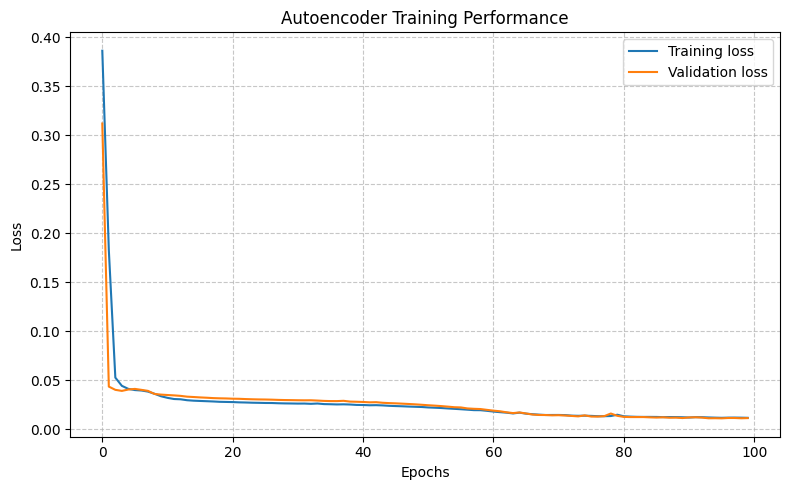

In [11]:
# Cell 11: Plot Autoencoder Training Performance
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Autoencoder Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
# Cell 12: Extract Encoded Features
print("Extracting encoded features...")
encoded_features = encoder.predict(reshaped_data)

Extracting encoded features...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [13]:
# Cell 13: Community detection using hierarchical clustering
n_communities = 5
print(f"Detecting {n_communities} communities using hierarchical clustering...")
community_model = AgglomerativeClustering(n_clusters=n_communities, linkage='ward')
community_labels = community_model.fit_predict(encoded_features)

Detecting 5 communities using hierarchical clustering...


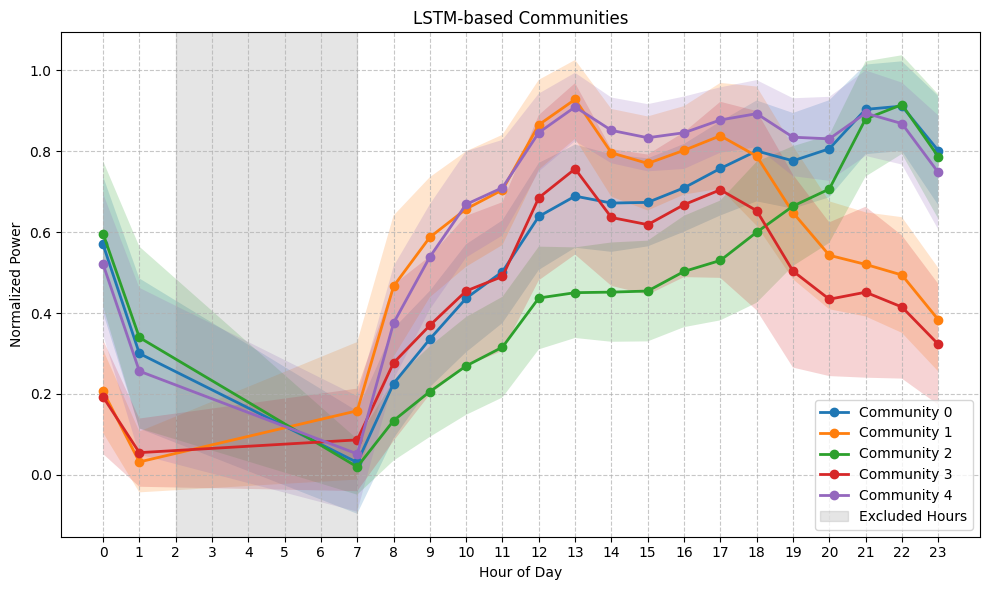

In [14]:
# Cell 14: Plot Community Detection Results
plt.figure(figsize=(10, 6))
for community in range(n_communities):
    community_data = normalized_df[community_labels == community].mean()
    plt.plot(hour_indices, community_data, linewidth=2, label=f'Community {community}', marker='o')
    community_std = normalized_df[community_labels == community].std()
    plt.fill_between(hour_indices, community_data - community_std, community_data + community_std, alpha=0.2)

plt.title('LSTM-based Communities')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Power')
plt.xticks(range(24))
plt.axvspan(2, 7, alpha=0.2, color='gray', label='Excluded Hours')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:
# # Cell 15: Plot 2D Visualization of Encoded Space (t-SNE)
# print("Generating 2D visualization of encoded features (t-SNE)...")
# tsne = TSNE(n_components=2, random_state=42)
# encoded_2d = tsne.fit_transform(encoded_features)

# plt.figure(figsize=(8, 6))
# for community in range(n_communities):
#     plt.scatter(
#         encoded_2d[community_labels == community, 0],
#         encoded_2d[community_labels == community, 1],
#         label=f'Community {community}',
#         alpha=0.7,
#     )

# plt.title('2D Visualization of Encoded Features (t-SNE)')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [16]:
# Cell 16: Helper functions for insights
from tslearn.metrics import dtw as tslearn_dtw # Ensure this import is present

def calculate_avg_dtw(data):
    n_samples = min(len(data), 10)  # Limit to 10 samples for efficiency
    if n_samples <= 1:
        return 0

    samples = data.sample(n_samples).values if len(data) > n_samples else data.values
    total_dtw = 0
    count = 0

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            total_dtw += tslearn_dtw(samples[i].reshape(-1, 1), samples[j].reshape(-1, 1))
            count += 1

    return total_dtw / max(1, count)

def classify_cluster_type(profile, hours_to_keep):
    hour_map = {col: hour for hour, col in zip(hours_to_keep, profile.index)}
    business_hours = [col for col, hour in hour_map.items() if 8 <= hour <= 18]
    night_hours = [col for col, hour in hour_map.items() if hour >= 19 or hour <= 1]  # Exclude 2-7am

    business_avg = profile[business_hours].mean()
    night_avg = profile[night_hours].mean()

    ratio = business_avg / (night_avg + 1e-10)

    if ratio > 1.5:
        return "Business/Industrial"
    elif ratio < 0.8:
        return "Residential"
    else:
        return "Mixed"

def classify_community_type(profile, hours_to_keep):
    return classify_cluster_type(profile, hours_to_keep)

In [17]:
# Cell 17: Calculate metrics and insights
print("\n=== Calculating Cluster Insights ===")
cluster_insights = {}
for cluster in range(n_clusters):
    cluster_data = normalized_df[kmeans_labels == cluster]
    mean_profile = cluster_data.mean()
    peak_hours = mean_profile.nlargest(3).index.tolist()
    std_profile = cluster_data.std()
    most_variable_hours = std_profile.nlargest(3).index.tolist()

    cluster_insights[f'Cluster_{cluster}'] = {
        'size': (kmeans_labels == cluster).sum(),
        'peak_hours': peak_hours,
        'most_variable_hours': most_variable_hours,
        'average_profile': mean_profile.to_dict(),
        'intra_cluster_dtw': calculate_avg_dtw(cluster_data),
        'type': classify_cluster_type(mean_profile, hours_to_keep)
    }
    print(f"Cluster_{cluster}: {cluster_insights[f'Cluster_{cluster}']['size']} stations, Type: {cluster_insights[f'Cluster_{cluster}']['type']}, Peak hours: {cluster_insights[f'Cluster_{cluster}']['peak_hours']}")

print("\n=== Calculating Community Insights ===")
community_insights = {}
for community in range(n_communities):
    community_data = normalized_df[community_labels == community]
    mean_profile = community_data.mean()
    peak_hours = mean_profile.nlargest(3).index.tolist()

    community_insights[f'Community_{community}'] = {
        'size': (community_labels == community).sum(),
        'peak_hours': peak_hours,
        'average_profile': mean_profile.to_dict(),
        'composition': {
            f'Cluster_{c}': ((kmeans_labels == c) & (community_labels == community)).sum()
            for c in range(n_clusters)
        },
        'type': classify_community_type(mean_profile, hours_to_keep)
    }
    print(f"Community_{community}: {community_insights[f'Community_{community}']['size']} stations, Type: {community_insights[f'Community_{community}']['type']}, Peak hours: {community_insights[f'Community_{community}']['peak_hours']}")
    print(f"  Composition: {community_insights[f'Community_{community}']['composition']}")


=== Calculating Cluster Insights ===
Cluster_0: 398 stations, Type: Residential, Peak hours: [22, 21, 23]
Cluster_1: 120 stations, Type: Business/Industrial, Peak hours: [13, 12, 17]
Cluster_2: 225 stations, Type: Mixed, Peak hours: [18, 17, 13]

=== Calculating Community Insights ===
Community_0: 354 stations, Type: Mixed, Peak hours: [22, 21, 20]
  Composition: {'Cluster_0': 267, 'Cluster_1': 1, 'Cluster_2': 86}
Community_1: 134 stations, Type: Business/Industrial, Peak hours: [13, 12, 17]
  Composition: {'Cluster_0': 0, 'Cluster_1': 73, 'Cluster_2': 61}
Community_2: 95 stations, Type: Residential, Peak hours: [22, 21, 23]
  Composition: {'Cluster_0': 79, 'Cluster_1': 1, 'Cluster_2': 15}
Community_3: 64 stations, Type: Business/Industrial, Peak hours: [13, 17, 12]
  Composition: {'Cluster_0': 0, 'Cluster_1': 45, 'Cluster_2': 19}
Community_4: 96 stations, Type: Mixed, Peak hours: [13, 21, 18]
  Composition: {'Cluster_0': 52, 'Cluster_1': 0, 'Cluster_2': 44}


In [18]:
# Cell 18: Prepare and Print Detailed Results
detailed_results = pd.DataFrame({
    'Site': sites,
    'K-means Cluster': kmeans_labels,
    'Community': community_labels
})

print("\n=== Detailed Results ===")
print(detailed_results.head())


=== Detailed Results ===
   Site  K-means Cluster  Community
0  A001                0          0
1  A002                2          0
2  A004                0          2
3  A005                0          0
4  A006                1          3


In [19]:
# Cell 19: Define GRU Autoencoder Model
print("Building GRU Autoencoder...")
timesteps = normalized_data.shape[1]  # Should be 18 now (24 - 6)
features = 1
encoding_dim = 8

# Build encoder with GRU
inputs_gru = Input(shape=(timesteps, features))
encoded_gru = GRU(32, activation='relu', return_sequences=True)(inputs_gru)
encoded_gru = GRU(16, activation='relu')(encoded_gru)
encoded_gru = Dense(encoding_dim, activation='relu')(encoded_gru)

# Build decoder with GRU
decoder_input_gru = Input(shape=(encoding_dim,))
decoded_gru = RepeatVector(timesteps)(decoder_input_gru)
decoded_gru = GRU(16, activation='relu', return_sequences=True)(decoded_gru)
decoded_gru = GRU(32, activation='relu', return_sequences=True)(decoded_gru)
decoded_gru = TimeDistributed(Dense(features))(decoded_gru)

# Define autoencoder model
autoencoder_gru = Model(inputs_gru, Model(decoder_input_gru, decoded_gru)(encoded_gru))
encoder_gru = Model(inputs_gru, encoded_gru)

# Compile autoencoder
autoencoder_gru.compile(optimizer='adam', loss='mse')

Building GRU Autoencoder...


In [20]:
# Cell 20: Train GRU Autoencoder
print("Training GRU Autoencoder...")
reshaped_data = normalized_data.reshape(len(normalized_data), timesteps, features)
history_gru = autoencoder_gru.fit(
    reshaped_data,
    reshaped_data,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=0,
)

Training GRU Autoencoder...


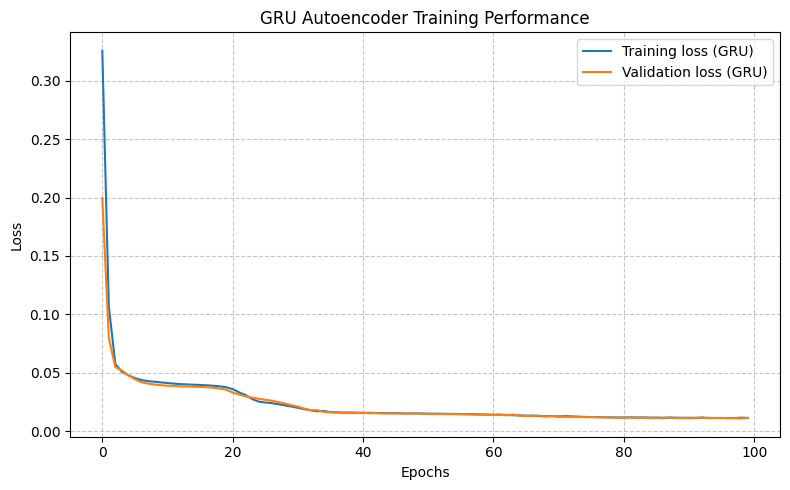

In [21]:
# Cell 21: Plot GRU Autoencoder Training Performance
plt.figure(figsize=(8, 5))
plt.plot(history_gru.history['loss'], label='Training loss (GRU)')
plt.plot(history_gru.history['val_loss'], label='Validation loss (GRU)')
plt.title('GRU Autoencoder Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
# Cell 22: Extract Encoded Features from GRU
print("Extracting encoded features from GRU...")
encoded_features_gru = encoder_gru.predict(reshaped_data)

Extracting encoded features from GRU...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [23]:
# Cell 23: Community detection using hierarchical clustering with GRU features
n_communities_gru = 5
print(f"Detecting {n_communities_gru} communities using hierarchical clustering (GRU features)...")
community_model_gru = AgglomerativeClustering(n_clusters=n_communities_gru, linkage='ward')
community_labels_gru = community_model_gru.fit_predict(encoded_features_gru)

Detecting 5 communities using hierarchical clustering (GRU features)...


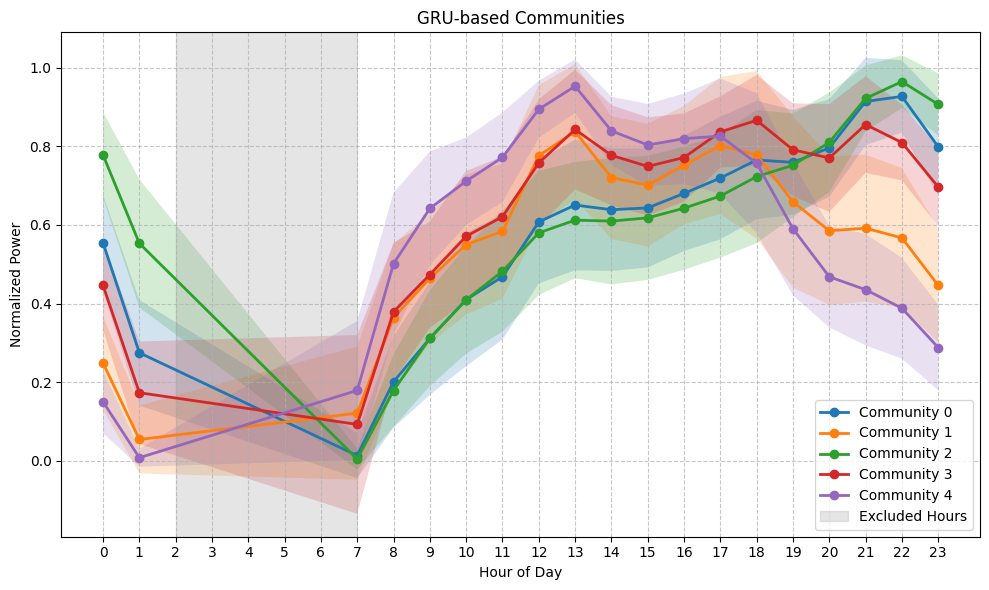

In [24]:
# Cell 24: Plot Community Detection Results (GRU features)
plt.figure(figsize=(10, 6))
for community in range(n_communities_gru):
    community_data = normalized_df[community_labels_gru == community].mean()
    plt.plot(hour_indices, community_data, linewidth=2, label=f'Community {community}', marker='o')
    community_std = normalized_df[community_labels_gru == community].std()
    plt.fill_between(hour_indices, community_data - community_std, community_data + community_std, alpha=0.2)

plt.title('GRU-based Communities')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Power')
plt.xticks(range(24))
plt.axvspan(2, 7, alpha=0.2, color='gray', label='Excluded Hours')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
# # Cell 25: Plot 2D Visualization of Encoded Space (t-SNE) with GRU features
# print("Generating 2D visualization of encoded features (t-SNE) with GRU...")
# tsne_gru = TSNE(n_components=2, random_state=42)
# encoded_2d_gru = tsne_gru.fit_transform(encoded_features_gru)

# plt.figure(figsize=(8, 6))
# for community in range(n_communities_gru):
#     plt.scatter(
#         encoded_2d_gru[community_labels_gru == community, 0],
#         encoded_2d_gru[community_labels_gru == community, 1],
#         label=f'Community {community}',
#         alpha=0.7,
#     )

# plt.title('2D Visualization of Encoded Features (t-SNE) - GRU')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

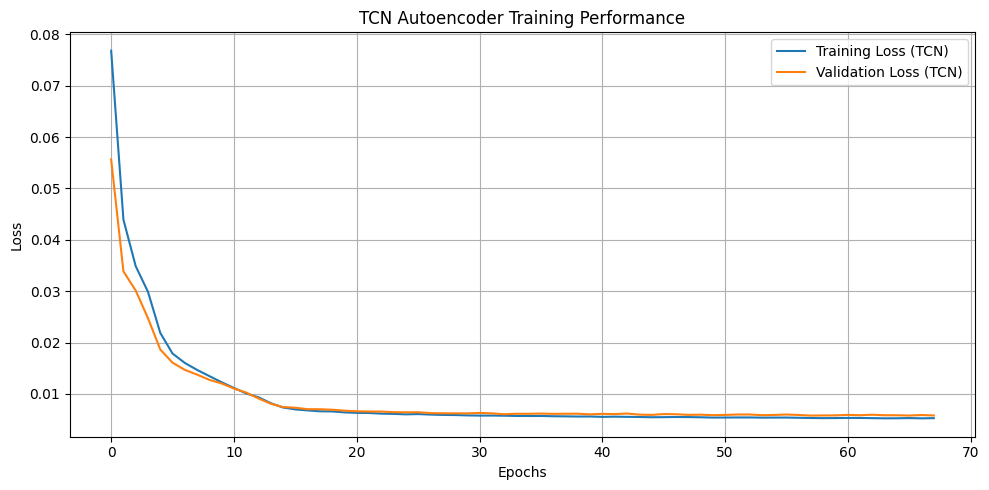

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


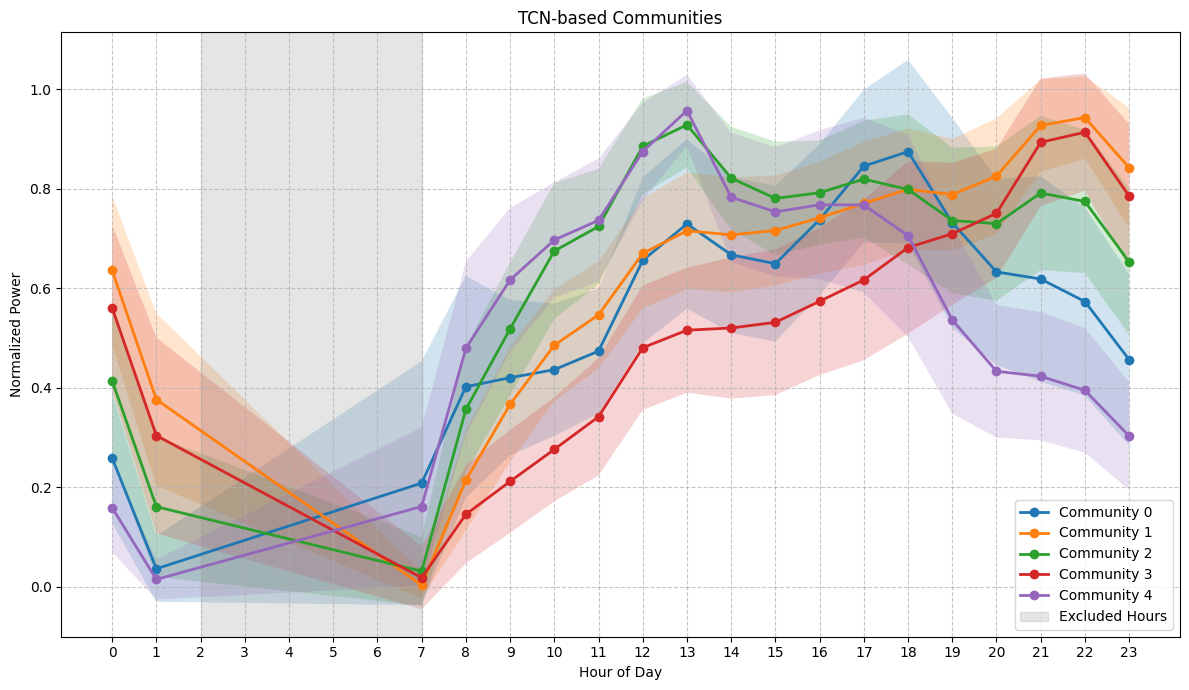

In [26]:
# Define TCN Autoencoder Model
timesteps = normalized_data.shape[1]
features = 1
encoding_dim = 8

input_tcn = Input(shape=(timesteps, features))

# Encoder
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', dilation_rate=1)(input_tcn)
conv2 = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', dilation_rate=2)(conv1)
flat = Flatten()(conv2)
encoded_tcn = Dense(encoding_dim, activation='relu')(flat)

# Decoder
dense_decoded = Dense(16 * timesteps, activation='relu')(encoded_tcn)
reshaped_decoded = Reshape((timesteps, 16))(dense_decoded)
conv_t_1 = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', dilation_rate=2)(reshaped_decoded)
conv_t_2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', dilation_rate=1)(conv_t_1)
decoded_tcn = Conv1D(filters=features, kernel_size=3, activation='sigmoid', padding='same')(conv_t_2)

autoencoder_tcn = Model(input_tcn, decoded_tcn)
encoder_tcn = Model(input_tcn, encoded_tcn)

autoencoder_tcn.compile(optimizer='adam', loss='mse')

# Reshape data for TCN input
reshaped_data_tcn = normalized_data.reshape(len(normalized_data), timesteps, features)

# Train TCN Autoencoder
epochs = 100
batch_size = 32
history_tcn = autoencoder_tcn.fit(
    reshaped_data_tcn,
    reshaped_data_tcn,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=0,
)

# Plot TCN Autoencoder Training Performance
plt.figure(figsize=(10, 5))
plt.plot(history_tcn.history['loss'], label='Training Loss (TCN)')
plt.plot(history_tcn.history['val_loss'], label='Validation Loss (TCN)')
plt.title('TCN Autoencoder Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract Encoded Features from TCN
encoded_features_tcn = encoder_tcn.predict(reshaped_data_tcn)

# Community detection using hierarchical clustering with TCN features
n_communities_tcn = 5
community_model_tcn = AgglomerativeClustering(n_clusters=n_communities_tcn, linkage='ward')
community_labels_tcn = community_model_tcn.fit_predict(encoded_features_tcn)

# Plot Community Detection Results (TCN features)
plt.figure(figsize=(12, 7))
hour_indices = hours_to_keep
for community in range(n_communities_tcn):
    community_data = normalized_df[community_labels_tcn == community].mean()
    plt.plot(hour_indices, community_data, linewidth=2, label=f'Community {community}', marker='o')
    community_std = normalized_df[community_labels_tcn == community].std()
    plt.fill_between(hour_indices, community_data - community_std, community_data + community_std, alpha=0.2)

plt.title('TCN-based Communities')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Power')
plt.xticks(range(24))
plt.axvspan(2, 7, alpha=0.2, color='gray', label='Excluded Hours')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# # Plot 2D Visualization of Encoded Space (t-SNE) with TCN features
# tsne_tcn = TSNE(n_components=3, random_state=42)
# encoded_2d_tcn = tsne_tcn.fit_transform(encoded_features_tcn)

# plt.figure(figsize=(10, 8))
# for community in range(n_communities_tcn):
#     plt.scatter(
#         encoded_2d_tcn[community_labels_tcn == community, 0],
#         encoded_2d_tcn[community_labels_tcn == community, 1],
#         label=f'Community {community}',
#         alpha=0.7,
#     )

# plt.title('2D Visualization of Encoded Features (t-SNE) - TCN')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()



In [27]:
# Create a DataFrame to store the classification types by each model
classification_df = pd.DataFrame({'BS Name': sites})

# Function to get the classification type for a given label and model
def get_classification_type(labels, normalized_df, classify_function, hours_to_keep):
    unique_labels = sorted(list(set(labels)))
    type_mapping = {}
    for label in unique_labels:
        mean_profile = normalized_df[labels == label].mean()
        type_mapping[label] = classify_function(mean_profile, hours_to_keep)
    return [type_mapping[label] for label in labels]

# Get K-Means classification types
kmeans_types = get_classification_type(kmeans_labels, normalized_df, classify_cluster_type, hours_to_keep)
classification_df['KMeans'] = kmeans_types

# Get LSTM classification types
lstm_types = get_classification_type(community_labels, normalized_df, classify_community_type, hours_to_keep)
classification_df['LSTM'] = lstm_types

# Get GRU classification types
gru_types = get_classification_type(community_labels_gru, normalized_df, classify_community_type, hours_to_keep)
classification_df['GRU'] = gru_types

# Get TCN classification types
tcn_types = get_classification_type(community_labels_tcn, normalized_df, classify_community_type, hours_to_keep)
classification_df['TCN'] = tcn_types
print(classification_df.head())

  BS Name               KMeans                 LSTM          GRU          TCN
0    A001          Residential                Mixed  Residential        Mixed
1    A002                Mixed                Mixed        Mixed        Mixed
2    A004          Residential          Residential  Residential  Residential
3    A005          Residential                Mixed  Residential        Mixed
4    A006  Business/Industrial  Business/Industrial        Mixed        Mixed


In [28]:
def get_voted_row(row):
    # Get all predictions excluding the BS Name
    predictions = [row['KMeans'], row['LSTM'], row['GRU'], row['TCN']]

    # Count occurrences of each prediction
    count = Counter(predictions)

    # Get the most common predictions and their counts
    most_common = count.most_common()

    # If there's a clear majority (more than 2 votes)
    if most_common[0][1] > 2:
        return most_common[0][0]
    # If it's a 2-2 tie
    elif most_common[0][1] == 2 and len(most_common) > 1 and most_common[1][1] == 2:
        # Prefer TCN's prediction in case of tie
        return row['TCN']
    else:
        return most_common[0][0]

# Apply the function to each row to create the new column
classification_df['voted'] = classification_df.apply(get_voted_row, axis=1)
classification_df.to_csv('Final clusters.csv')
classification_df.head()

,BS Name,KMeans,LSTM,GRU,TCN,voted
0,A001,Residential,Mixed,Residential,Mixed,Mixed
1,A002,Mixed,Mixed,Mixed,Mixed,Mixed
2,A004,Residential,Residential,Residential,Residential,Residential
3,A005,Residential,Mixed,Residential,Mixed,Mixed
4,A006,Business/Industrial,Business/Industrial,Mixed,Mixed,Mixed


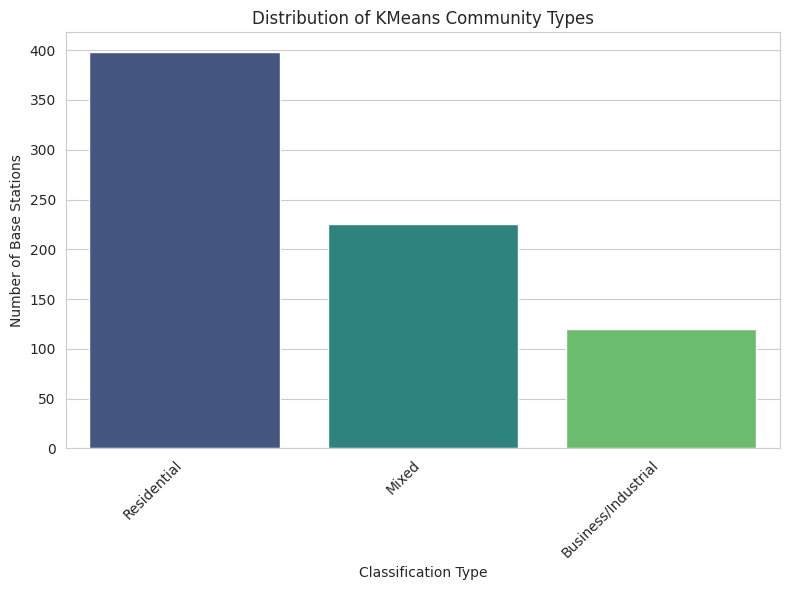

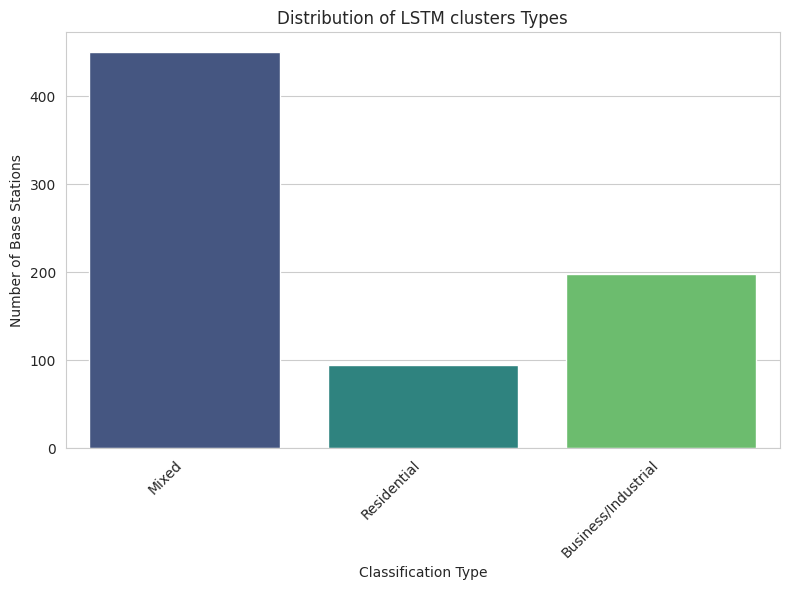

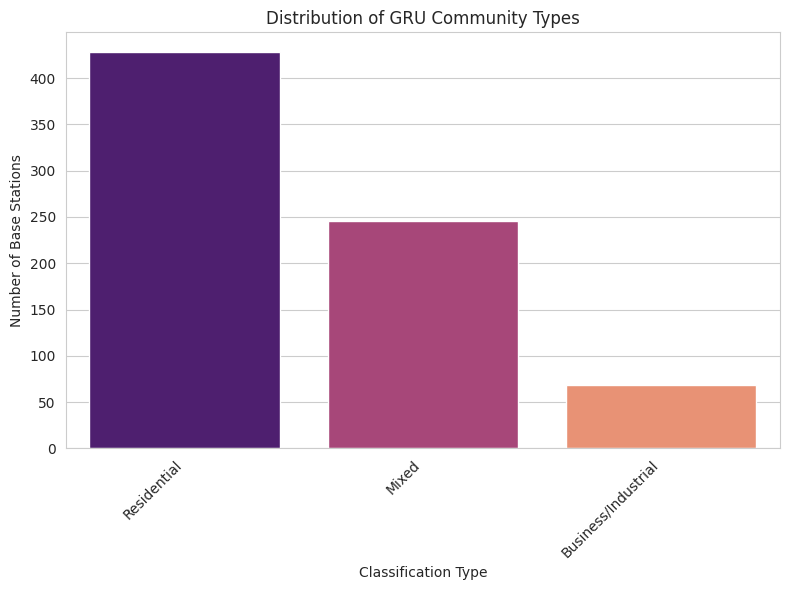

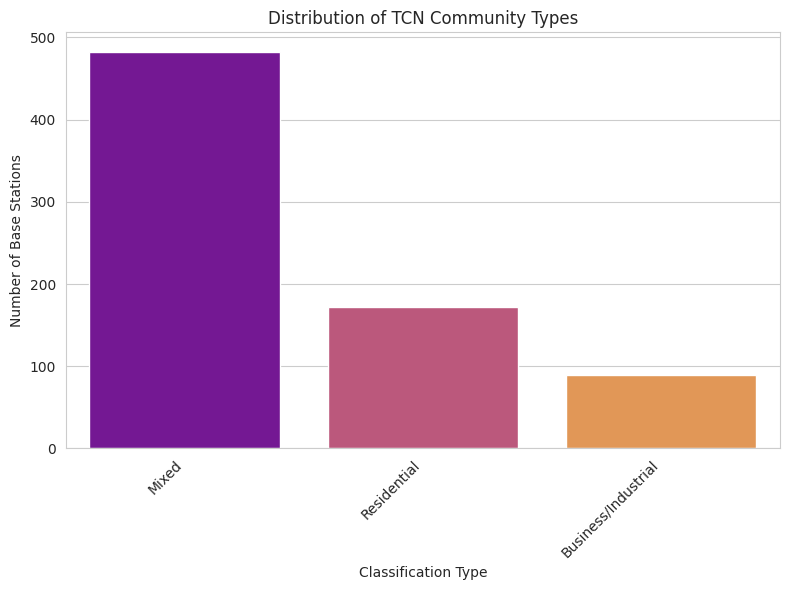

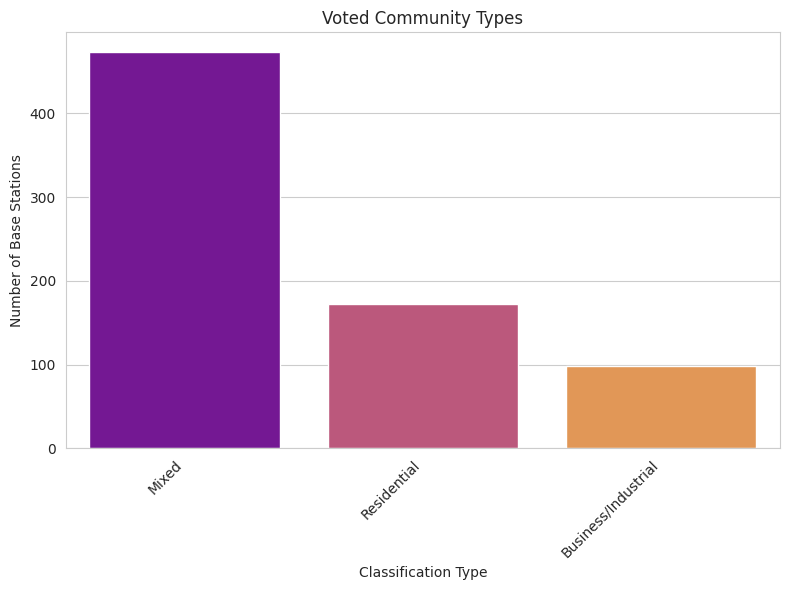

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nicer style for the plots
sns.set_style("whitegrid")

# --- Visualization for LSTM ---
plt.figure(figsize=(8, 6))
sns.countplot(data=classification_df, x='KMeans', palette='viridis')
plt.title('Distribution of KMeans Community Types')
plt.xlabel('Classification Type')
plt.ylabel('Number of Base Stations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Visualization for LSTM ---
plt.figure(figsize=(8, 6))
sns.countplot(data=classification_df, x='LSTM', palette='viridis')
plt.title('Distribution of LSTM clusters Types')
plt.xlabel('Classification Type')
plt.ylabel('Number of Base Stations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Visualization for GRU ---
plt.figure(figsize=(8, 6))
sns.countplot(data=classification_df, x='GRU', palette='magma')
plt.title('Distribution of GRU Community Types')
plt.xlabel('Classification Type')
plt.ylabel('Number of Base Stations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Visualization for TCN ---
plt.figure(figsize=(8, 6))
sns.countplot(data=classification_df, x='TCN', palette='plasma')
plt.title('Distribution of TCN Community Types')
plt.xlabel('Classification Type')
plt.ylabel('Number of Base Stations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
sns.countplot(data=classification_df, x='voted', palette='plasma')
plt.title('Voted Community Types')
plt.xlabel('Classification Type')
plt.ylabel('Number of Base Stations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [30]:
# Load Data
df = pd.read_excel(data_path)
sites = df['site']
power_data = df.iloc[:, 1:]

# Filter out hours
hours_to_keep = [0, 1] + list(range(7, 24))
filtered_power_data = power_data.iloc[:, hours_to_keep]

# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(filtered_power_data.T).T
normalized_df = pd.DataFrame(
    normalized_data,
    columns=[filtered_power_data.columns[i] for i in range(len(filtered_power_data.columns))],
    index=filtered_power_data.index,
)